In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import zipfile
import cv2
import os
import shutil
import glob
import pandas as pd
import numpy as np
import random
from google.colab import drive
from tqdm import tqdm
from imutils import paths
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, ReLU
import warnings
warnings.filterwarnings('ignore')
tf.__version__

'2.17.1'

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [4]:
# train/test/validation split and save

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
IMAGE_DIR_CLASSWISE = "/content/PBC_dataset_normal_DIB"
IMAGE_DIR_SPLITTED = "/content/PBC_dataset_splitted"
IMAGE_DIR_SPLITTED_TRAIN = f"{IMAGE_DIR_SPLITTED}/train"
IMAGE_DIR_DOWNSAMPLED_TRAIN = f"{IMAGE_DIR_SPLITTED}/train_downsampled"
# IMAGE_DIR_OVERSAMPLED = "/content/PBC_dataset_oversampled"

def save_images_generator_format(image_dir_classwise:str=IMAGE_DIR_CLASSWISE,image_dir_splitted:str=IMAGE_DIR_SPLITTED):
	# derive the training, validation, and testing directories
	TRAIN_PATH = os.path.sep.join([image_dir_splitted, "train"])
	VAL_PATH = os.path.sep.join([image_dir_splitted, "val"])
	TEST_PATH = os.path.sep.join([image_dir_splitted, "test"])

	totalTrain = len(list(paths.list_images(TRAIN_PATH)))
	totalVal = len(list(paths.list_images(VAL_PATH)))
	totalTest = len(list(paths.list_images(TEST_PATH)))

	# grab the paths to all input images in the original input directory
	# and shuffle them
	imagePaths = list(paths.list_images(IMAGE_DIR_CLASSWISE))
	random.seed(42)
	random.shuffle(imagePaths)
	# compute the training and testing split
	i = int(len(imagePaths) * TRAIN_SPLIT)
	trainPaths = imagePaths[:i]
	testPaths = imagePaths[i:]
	# using part of the training data for validation
	i = int(len(trainPaths) * VAL_SPLIT)
	valPaths = trainPaths[:i]
	trainPaths = trainPaths[i:]
	# define the datasets
	datasets = [
		("training", trainPaths, TRAIN_PATH),
		("validation", valPaths, VAL_PATH),
		("testing", testPaths, TEST_PATH)
	]
	# loop over the datasets
	for (dType, imagePaths, baseOutput) in datasets:
		# show which data split we are creating
		print("[INFO] building '{}' split".format(dType))
		# if the output base output directory does not exist, create it
		if not os.path.exists(baseOutput):
			print("[INFO] 'creating {}' directory".format(baseOutput))
			os.makedirs(baseOutput)
		# loop over the input image paths
		for inputPath in imagePaths:
			# extract the filename of the input image along with its
			# corresponding class label
			filename = inputPath.split(os.path.sep)[-1]
			label = inputPath.split(os.path.sep)[-2].replace(IMAGE_DIR_CLASSWISE, '')
			# build the path to the label directory
			labelPath = os.path.sep.join([baseOutput, label])
			# if the label output directory does not exist, create it
			if not os.path.exists(labelPath):
				print("[INFO] 'creating {}' directory".format(labelPath))
				os.makedirs(labelPath)
			# construct the path to the destination image and then copy
			# the image itself
			p = os.path.sep.join([labelPath, filename])
			shutil.copy2(inputPath, p)

def oversample_minority_classes():
	pass

def downsample_majority_classes(original_dataset_path:str=IMAGE_DIR_SPLITTED_TRAIN,undersampled_dataset_path:str=IMAGE_DIR_DOWNSAMPLED_TRAIN):
	# identify class counts
	class_counts = {}
	for class_name in os.listdir(original_dataset_path):
			class_dir = os.path.join(original_dataset_path, class_name)
			if os.path.isdir(class_dir):
					class_counts[class_name] = len(os.listdir(class_dir))

	# determine the minority class count
	minority_count = min(class_counts.values())
	print(f"Minority class count: {minority_count}")

	# undersample majority classes
	for class_name, count in class_counts.items():
			print(f"Processing class: {class_name}")
			class_dir = os.path.join(original_dataset_path, class_name)
			save_dir = os.path.join(undersampled_dataset_path, class_name)
			os.makedirs(save_dir, exist_ok=True)

			# Randomly select images to keep
			images = os.listdir(class_dir)
			if count > minority_count:
					images_to_keep = random.sample(images, minority_count)
			else:
					images_to_keep = images  # Keep all images if count <= minority_count

			# Copy selected images to the new undersampled directory
			for img in images_to_keep:
					src_path = os.path.join(class_dir, img)
					dest_path = os.path.join(save_dir, img)
					shutil.copy(src_path, dest_path)

	print("image random undersampling completed.")

In [5]:
# 1. extract the zip file to Google colab instance
ZIP_FILE_DIR = "/content/drive/MyDrive/Chamara-alzheimer-disease-classifier-ViT/PBC_dataset_normal_DIB.zip"

zip_object = zipfile.ZipFile(file=ZIP_FILE_DIR, mode='r')
zip_object.extractall('./')
zip_object.close()

In [6]:
# 2. remove the platelet class from dataset
import os
import shutil

REMOVE_DIR = "/content/PBC_dataset_normal_DIB/platelet"

if os.path.exists(REMOVE_DIR):
    shutil.rmtree(REMOVE_DIR)

In [7]:
# 3. split the data to train/test/val
save_images_generator_format()

# 4. downsample the majority classes in train set only
downsample_majority_classes()

[INFO] building 'training' split
[INFO] 'creating /content/PBC_dataset_splitted/train' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/basophil' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/ig' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/eosinophil' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/erythroblast' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/monocyte' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/neutrophil' directory
[INFO] 'creating /content/PBC_dataset_splitted/train/lymphocyte' directory
[INFO] building 'validation' split
[INFO] 'creating /content/PBC_dataset_splitted/val' directory
[INFO] 'creating /content/PBC_dataset_splitted/val/neutrophil' directory
[INFO] 'creating /content/PBC_dataset_splitted/val/eosinophil' directory
[INFO] 'creating /content/PBC_dataset_splitted/val/erythroblast' directory
[INFO] 'creating /content/PBC_dataset_splitted/val/ig' directory
[INFO

In [ ]:
# import os
# import shutil

# if os.path.exists(CLASSWISE_IMAGE_DIR):
#     shutil.rmtree(CLASSWISE_IMAGE_DIR)

In [16]:
# params
IMAGE_SIZE = 380 # 224, 300, 448
MEAN_VECTOR = [0.485, 0.456, 0.406] # [0.485, 0.456, 0.406] [0.5]
STD_VECTOR = [0.229, 0.224, 0.225] # [0.229, 0.224, 0.225] [0.5]
BATCH_SIZE = 32 # 16, 32, 64, 128
LEARNING_RATE = 0.001 # 0.001, 0.0003
EPOCHS = 10 # 10, 15, 20, 25, 40 ,50
PATIENCE = 4 # 5, 8
WEIGHT_DECAY = 1e-4

In [17]:
TRAIN_SET_PATH = IMAGE_DIR_DOWNSAMPLED_TRAIN # f"{IMAGE_DIR_SPLITTED}/train"
TEST_SET_PATH = f"{IMAGE_DIR_SPLITTED}/test"
VAL_SET_PATH = f"{IMAGE_DIR_SPLITTED}/val"

def normalize_image(img):
    mean = np.array(MEAN_VECTOR)
    std = np.array(STD_VECTOR)
    return (img - mean) / std

# train
training_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=normalize_image,  # Apply mean normalization
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.2)
train_dataset = training_generator.flow_from_directory(TRAIN_SET_PATH,
                                                        target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

# test
test_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=normalize_image,  # Apply mean normalization
    )
test_dataset = test_generator.flow_from_directory(TEST_SET_PATH,
                                                     target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

# val
val_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=normalize_image,  # Apply mean normalization
)
val_dataset = val_generator.flow_from_directory(VAL_SET_PATH,
                                                     target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size = BATCH_SIZE,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

print(train_dataset.class_indices)

Found 6104 images belonging to 7 classes.
Found 2949 images belonging to 7 classes.
Found 1179 images belonging to 7 classes.
{'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6}


In [18]:
NUM_CLASSES = len(train_dataset.class_indices) # 3, 9, len(train_dataset.class_indices)

In [19]:
grade_model = tf.keras.applications.EfficientNetB4( # ResNet50V2, EfficientNetB4
    weights='imagenet', # imagenet
    include_top=False,
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    )

# # load a saved model - if available
# from tensorflow.keras.models import load_model

# model_path = '/content/drive/MyDrive/.../models/EffNet-B4/efficientnetb4_model.keras'
# grade_model = load_model(model_path) # Load the saved model

In [20]:
print(len(grade_model.layers))
grade_model.output

475


<KerasTensor shape=(None, 12, 12, 1792), dtype=float32, sparse=False, name=keras_tensor_963>

In [13]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

# unfreeze conv layers
def freeze_layers_except_batchnorm(model, bottom_layer, top_layer):
    model.trainable = True
    for layer in model.layers[bottom_layer:top_layer]:
      layer.trainable = False

    for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
          layer.trainable = False

# freeze_layers_except_batchnorm(grade_model, bottom_layer=0, top_layer=450)

In [ ]:
grade_model.layers

[<InputLayer name=input_layer, built=True>,
 <Rescaling name=rescaling, built=True>,
 <Normalization name=normalization, built=True>,
 <Rescaling name=rescaling_1, built=True>,
 <ZeroPadding2D name=stem_conv_pad, built=True>,
 <Conv2D name=stem_conv, built=True>,
 <BatchNormalization name=stem_bn, built=True>,
 <Activation name=stem_activation, built=True>,
 <DepthwiseConv2D name=block1a_dwconv, built=True>,
 <BatchNormalization name=block1a_bn, built=True>,
 <Activation name=block1a_activation, built=True>,
 <GlobalAveragePooling2D name=block1a_se_squeeze, built=True>,
 <Reshape name=block1a_se_reshape, built=True>,
 <Conv2D name=block1a_se_reduce, built=True>,
 <Conv2D name=block1a_se_expand, built=True>,
 <Multiply name=block1a_se_excite, built=True>,
 <Conv2D name=block1a_project_conv, built=True>,
 <BatchNormalization name=block1a_project_bn, built=True>,
 <DepthwiseConv2D name=block1b_dwconv, built=True>,
 <BatchNormalization name=block1b_bn, built=True>,
 <Activation name=block1

In [21]:
# head model
# modify the head model
y = grade_model.layers[-11].output
y = GlobalAveragePooling2D()(y)

y = Dense(units = 1024, activation=None)(y)
y = BatchNormalization()(y)
y = ReLU()(y)
y = Dropout(rate = 0.3)(y)

y = Dense(units = 128, activation=None)(y)
y = BatchNormalization()(y)
y = ReLU()(y)
y = Dropout(rate = 0.3)(y)

y = Dense(units = 32, activation=None)(y)
y = BatchNormalization()(y)
y = ReLU()(y)
y = Dropout(rate = 0.3)(y)

new_output = Dense(NUM_CLASSES, activation='softmax')(y)  # 7 classes

network_op1 = Model(inputs = grade_model.input, outputs = new_output)

network_op1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),  # Softmax output
    metrics=[keras.metrics.CategoricalAccuracy()])

In [22]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
]

history_op1 = network_op1.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[callbacks])

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - categorical_accuracy: 0.6980 - loss: 1.0129 - val_categorical_accuracy: 0.0992 - val_loss: 4.0094
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - categorical_accuracy: 0.9250 - loss: 0.3415 - val_categorical_accuracy: 0.4436 - val_loss: 2.7411
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - categorical_accuracy: 0.9393 - loss: 0.2582 - val_categorical_accuracy: 0.6930 - val_loss: 1.2179
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - categorical_accuracy: 0.9579 - loss: 0.1897 - val_categorical_accuracy: 0.6904 - val_loss: 2.0997
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - categorical_accuracy: 0.9591 - loss: 0.1761 - val_categorical_accuracy: 0.5700 - val_loss: 1.8846
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - categorical_accuracy: 0.9629 - loss: 0.1619 - val_categorical_accuracy: 0.9703 - val_loss: 0.1355
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - categorical_accuracy: 0.968

In [ ]:
network_op1.save('efficientnetb4_model_100_samples_each.keras')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot training & validation accuracy and loss
def plot_training_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

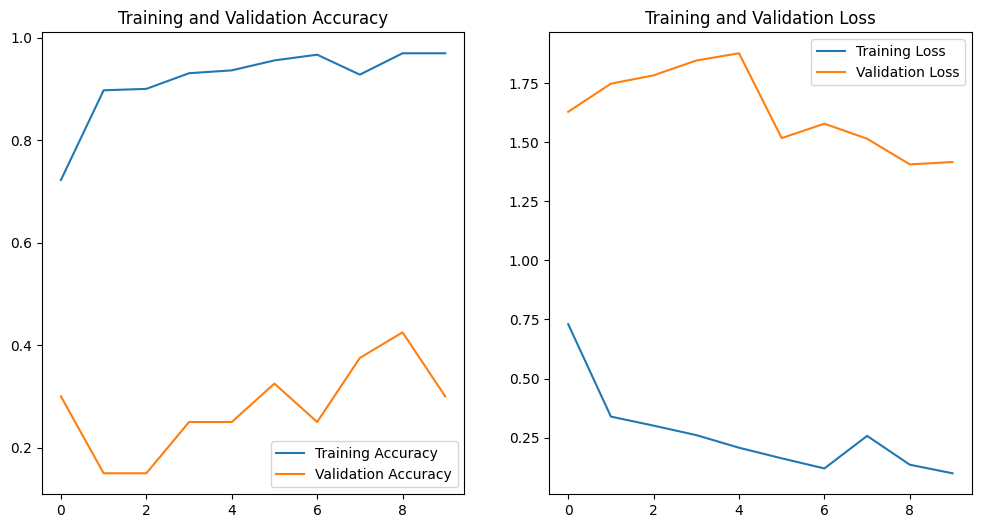

In [ ]:
plot_training_history(history_op1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 223ms/step - categorical_accuracy: 0.2771 - loss: 1.7853
Test Loss: 1.5338492393493652
Test Accuracy: 0.36000001430511475
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step


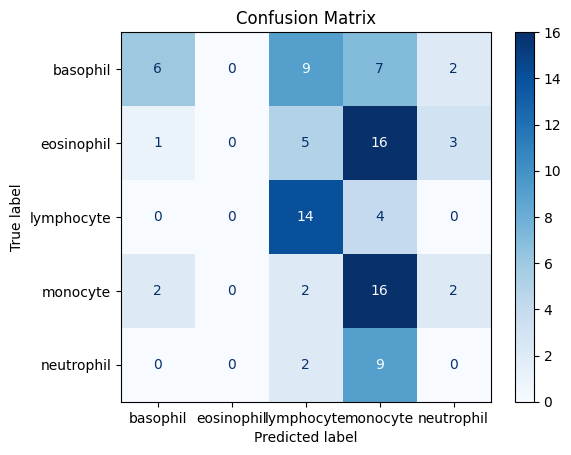

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = network_op1.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict the test set
test_predictions = network_op1.predict(test_dataset)
test_pred_classes = np.argmax(test_predictions, axis=1)
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, test_pred_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!scp -r efficientnetb4_model_6_classes.keras '/content/drive/MyDrive/bizzman/akbar/models/6_classes/efficientnetb4_model_6_classes.keras'